In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score
import torch
import gc
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
from sklearn.manifold import TSNE
import re
import string
import emoji

2025-12-02 15:42:29.120453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764690149.308519      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764690149.371435      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
file_path = "/kaggle/input/hate-speech-roman-urdu/Hate Speech Roman Urdu (HS-RU-20).xlsx"

print("Loading & Mapping Classes...")
try:
    df_hate = pd.read_excel(file_path, sheet_name='HateOffensive')
    df_neut = pd.read_excel(file_path, sheet_name='HostileNeutral')

    df_hate = df_hate.rename(columns={'Sentence': 'text'})
    df_neut = df_neut.rename(columns={'Sentence': 'text'})

    df_hate['label_name'] = df_hate.iloc[:, 1].map({'O': 'Offensive', 'H': 'Hate'})
    
    df_neut['label_name'] = df_neut.iloc[:, 1].map({'N': 'Neutral', 'H': 'Hostile'})

    df = pd.concat([df_hate, df_neut], ignore_index=True)
    
    df.dropna(subset=['text', 'label_name'], inplace=True)
    df['text'] = df['text'].astype(str)
    
    severity_map = {'Neutral': 0, 'Offensive': 1, 'Hostile': 2, 'Hate': 3}
    df['severity_score'] = df['label_name'].map(severity_map)
    
    print(f"Data Loaded! Total Rows: {len(df)}")
    print(df['label_name'].value_counts())

except Exception as e:
    print(f"Error: {e}")

Loading & Mapping Classes...
Data Loaded! Total Rows: 8569
label_name
Hostile      3575
Offensive    2690
Neutral      1424
Hate          880
Name: count, dtype: int64


In [3]:
display(df.head())
print("="*110)
display(df.tail())

,text,Offensive (O) / Hate (H),label_name,Neutral (N) / Hostile (H),severity_score
0,kya mein bhooka hon? kutia ab tum ney ye pooch...,O,Offensive,NaN,1
1,"khawateen ghaas ki tarah hain, inhen baqaidagi...",H,Hate,NaN,3
2,Afghani dehshat gard hotay hain,H,Hate,NaN,3
3,tamam sarkari hukkaam chor hain,O,Offensive,NaN,1
4,yeh mohabbat nahi hai kutia,O,Offensive,NaN,1


,text,Offensive (O) / Hate (H),label_name,Neutral (N) / Hostile (H),severity_score
8565,"maa behen ke baare me abhi tk baat nhi ki, jab...",NaN,Hostile,H,2
8566,aaj kal hamari awaz apney mulk mai bhi nahi su...,NaN,Neutral,N,0
8567,agar ye kutia meri zindagi mein na aye hoti to...,NaN,Hostile,H,2
8568,kab meray ghar aur zindagi se dafa ho rahi hai...,NaN,Hostile,H,2
8569,tarjumay se quran parho to maloom ho jaye ga k...,NaN,Neutral,N,0


Extracting Features...

Generating Dashboard...


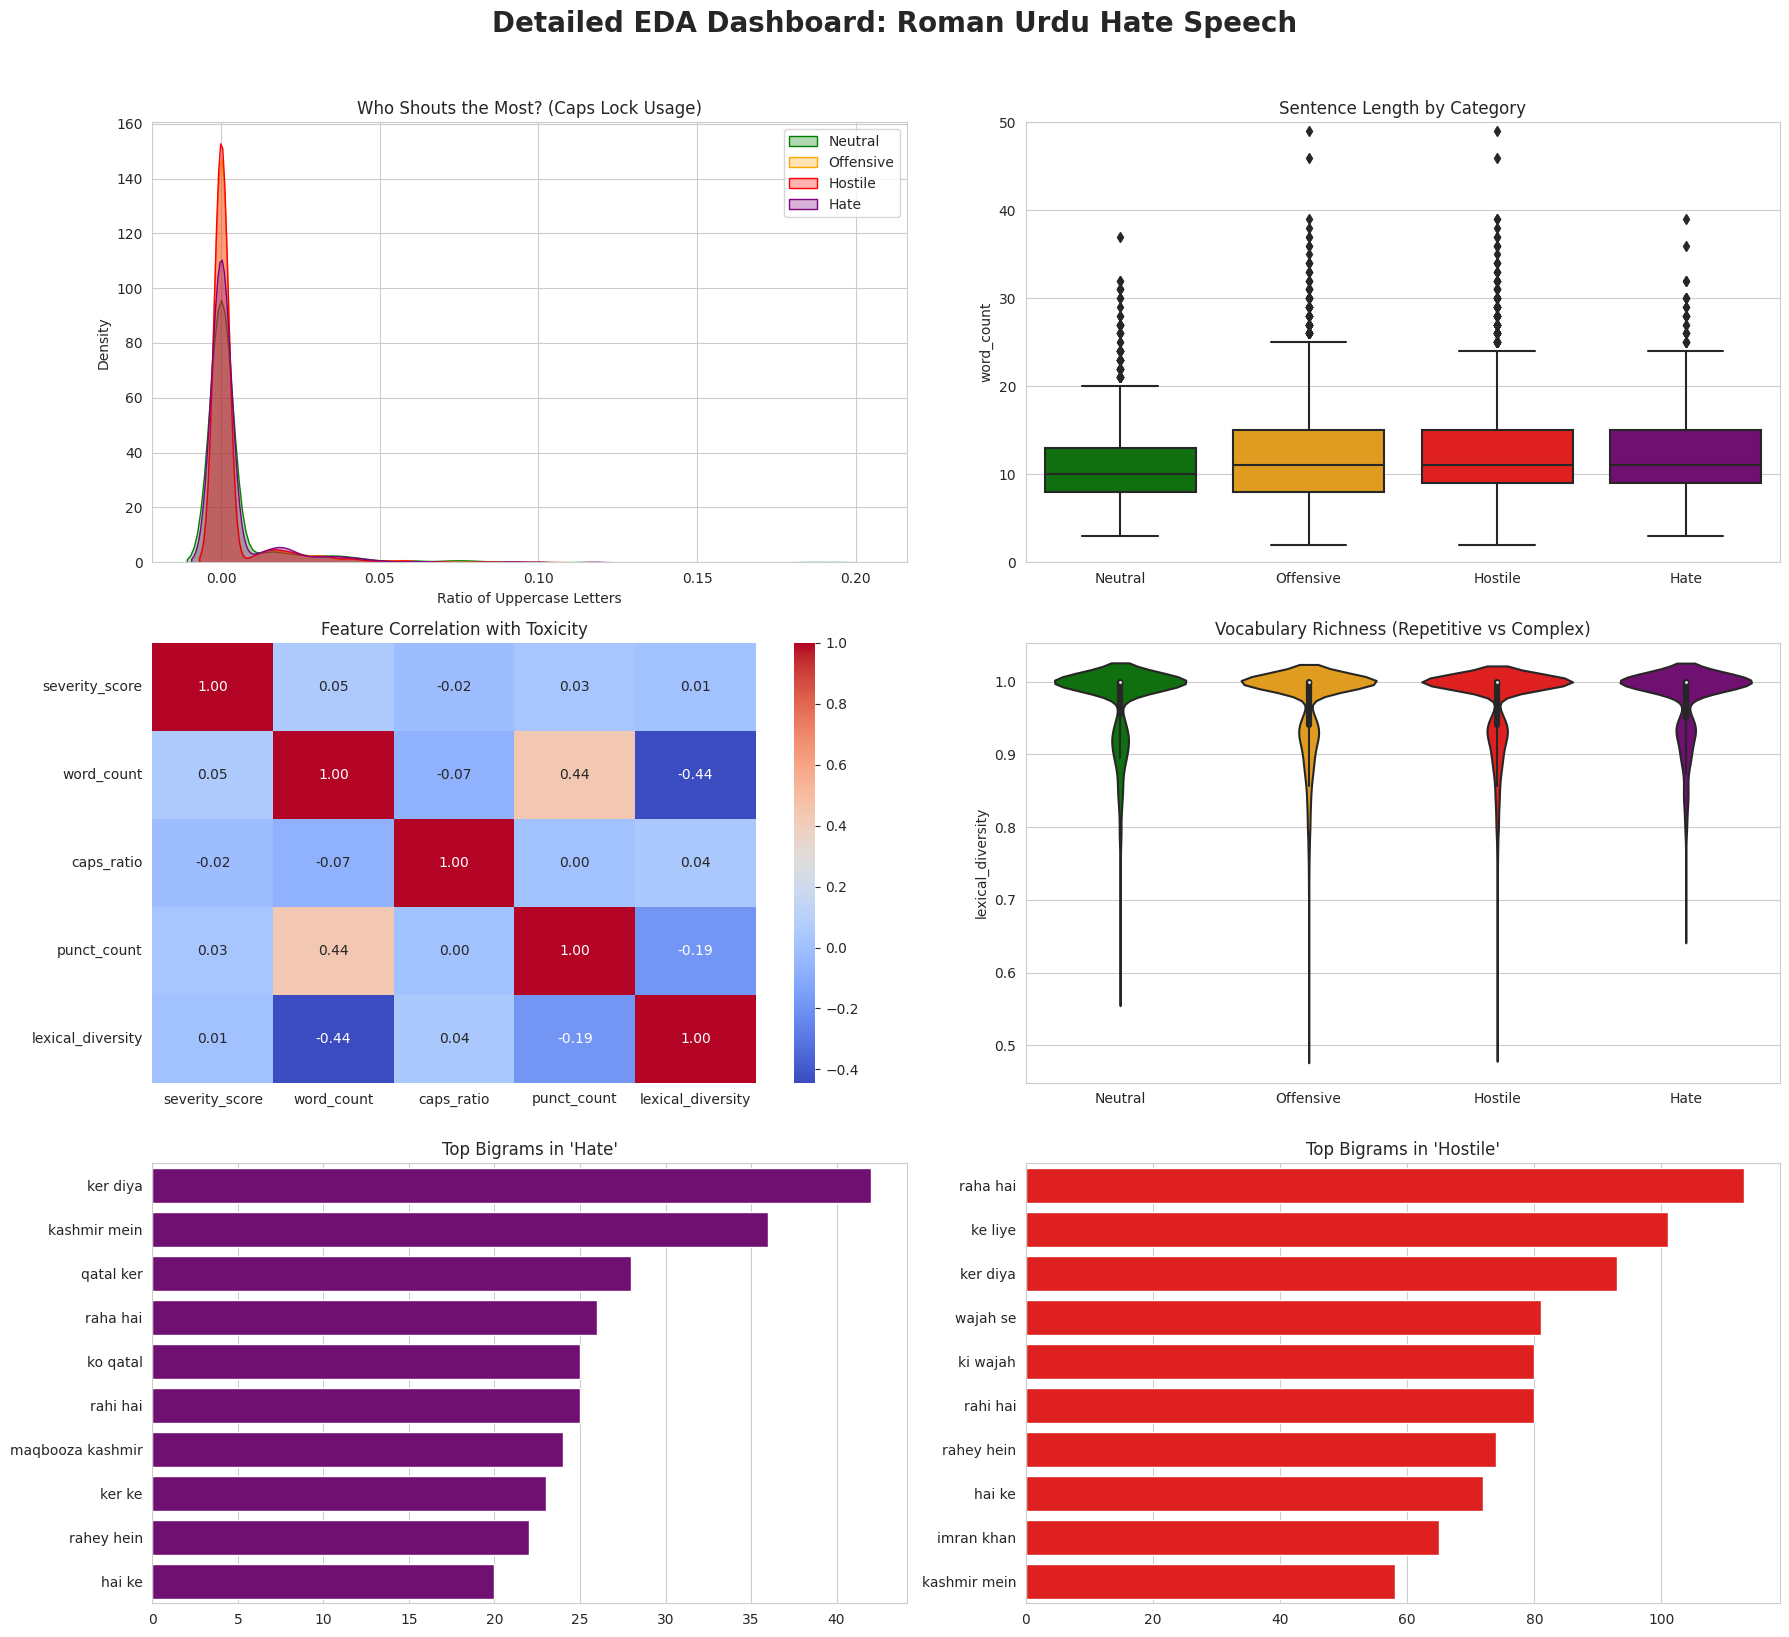

In [4]:
print("Extracting Features...")
def get_ttr(text):
    words = str(text).split()
    if not words: return 0
    return len(set(words)) / len(words)

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(len)
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
df['punct_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))
df['lexical_diversity'] = df['text'].apply(get_ttr)

print("\nGenerating Dashboard...")
sns.set_style("whitegrid")
custom_pal = {'Neutral': 'green', 'Offensive': 'orange', 'Hostile': 'red', 'Hate': 'purple'}
order_list = ['Neutral', 'Offensive', 'Hostile', 'Hate']

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
plt.suptitle("Detailed EDA Dashboard: Roman Urdu Hate Speech", fontsize=20, weight='bold', y=1.02)

for label in order_list:
    subset = df[df['label_name'] == label]
    sns.kdeplot(subset['caps_ratio'], fill=True, label=label, color=custom_pal[label], alpha=0.3, ax=axes[0,0])
axes[0,0].set_title("Who Shouts the Most? (Caps Lock Usage)")
axes[0,0].set_xlabel("Ratio of Uppercase Letters")
axes[0,0].legend()

sns.boxplot(x='label_name', y='word_count', data=df, order=order_list, palette=custom_pal, ax=axes[0,1])
axes[0,1].set_title("Sentence Length by Category")
axes[0,1].set_ylim(0, 50) 
axes[0,1].set_xlabel("")

severity_map = {'Neutral': 0, 'Offensive': 1, 'Hostile': 2, 'Hate': 3}
df['severity_score'] = df['label_name'].map(severity_map)
corr_cols = ['severity_score', 'word_count', 'caps_ratio', 'punct_count', 'lexical_diversity']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1,0])
axes[1,0].set_title("Feature Correlation with Toxicity")

sns.violinplot(x='label_name', y='lexical_diversity', data=df, order=order_list, palette=custom_pal, ax=axes[1,1])
axes[1,1].set_title("Vocabulary Richness (Repetitive vs Complex)")
axes[1,1].set_xlabel("")

def plot_top_ngrams_on_ax(data, label_target, ax, n=2, color='blue'):
    text_list = data[data['label_name'] == label_target]['text']
    vec = [word for text in text_list for word in str(text).lower().split()]
    ngram_counts = Counter(zip(*[vec[i:] for i in range(n)])).most_common(10)
    
    y = [" ".join(x) for x, count in ngram_counts]
    x = [count for x, count in ngram_counts]
    
    sns.barplot(x=x, y=y, ax=ax, color=color)
    ax.set_title(f"Top Bigrams in '{label_target}'")

plot_top_ngrams_on_ax(df, 'Hate', axes[2,0], n=2, color='purple')

plot_top_ngrams_on_ax(df, 'Hostile', axes[2,1], n=2, color='red')

plt.tight_layout()
plt.show()

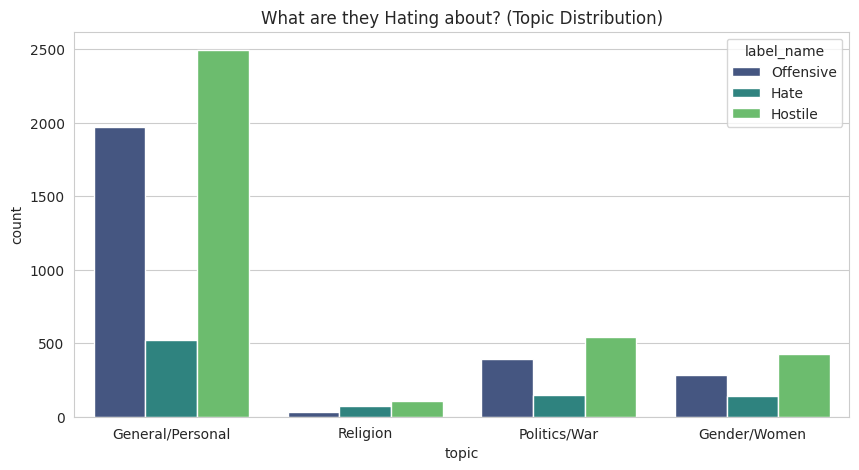


Top Emojis in HATE Speech:
[]

Top Emojis in NEUTRAL Speech:
[]

Identifying 'Trigger Words'...


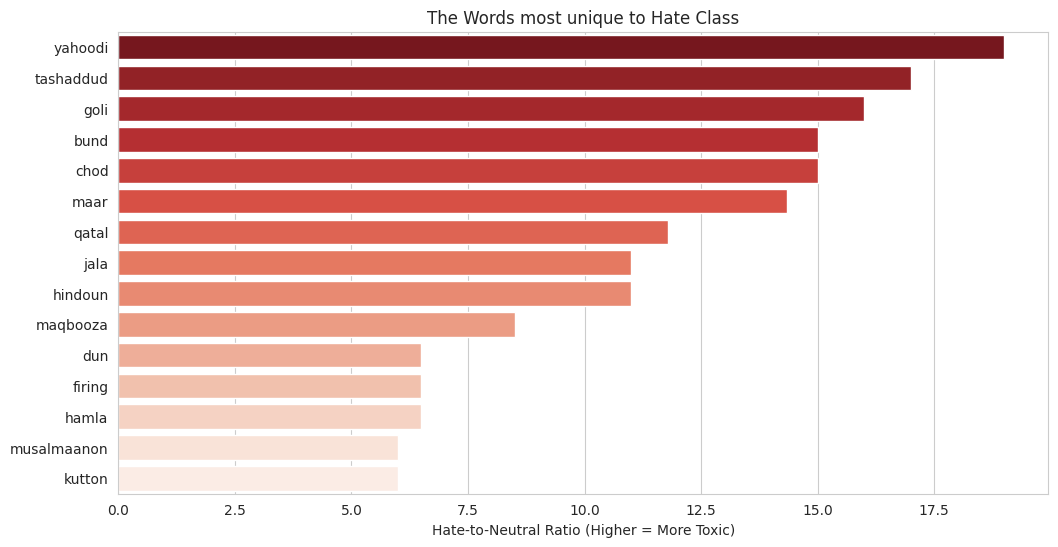

In [5]:
political_keywords = ['modi', 'india', 'indian', 'kashmir', 'army', 'fouj', 'khan', 'nawaz', 'ppp', 'pti', 'hukumat']
gender_keywords = ['aurat', 'larki', 'bhen', 'maa', 'beti', 'bibi', 'feminist']
religious_keywords = ['muslim', 'hindu', 'kafir', 'shia', 'sunni', 'islam', 'mazhab']

def tag_topic(text):
    text = str(text).lower()
    if any(k in text for k in political_keywords): return 'Politics/War'
    if any(k in text for k in gender_keywords): return 'Gender/Women'
    if any(k in text for k in religious_keywords): return 'Religion'
    return 'General/Personal'

df['topic'] = df['text'].apply(tag_topic)

plt.figure(figsize=(10, 5))
sns.countplot(x='topic', hue='label_name', data=df[df['label_name'] != 'Neutral'], palette='viridis')
plt.title("What are they Hating about? (Topic Distribution)")
plt.show()

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

df['emojis'] = df['text'].apply(extract_emojis)

hate_emojis = list(df[df['label_name']=='Hate']['emojis'].str.cat())
neutral_emojis = list(df[df['label_name']=='Neutral']['emojis'].str.cat())

print("\nTop Emojis in HATE Speech:")
print(Counter(hate_emojis).most_common(10))

print("\nTop Emojis in NEUTRAL Speech:")
print(Counter(neutral_emojis).most_common(10))

print("\nIdentifying 'Trigger Words'...")

def get_word_freq(text_series):
    return Counter(" ".join(text_series.astype(str)).lower().split())

hate_freq = get_word_freq(df[df['label_name']=='Hate']['text'])
neutral_freq = get_word_freq(df[df['label_name']=='Neutral']['text'])

toxic_words = {}
for word, count in hate_freq.items():
    if count > 10:
        neutral_count = neutral_freq.get(word, 0)
        ratio = count / (neutral_count + 1)
        toxic_words[word] = ratio

top_toxic = sorted(toxic_words.items(), key=lambda x: x[1], reverse=True)[:15]

words, scores = zip(*top_toxic)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(scores), y=list(words), palette='Reds_r')
plt.title("The Words most unique to Hate Class")
plt.xlabel("Hate-to-Neutral Ratio (Higher = More Toxic)")
plt.show()

Generating Word Clouds...


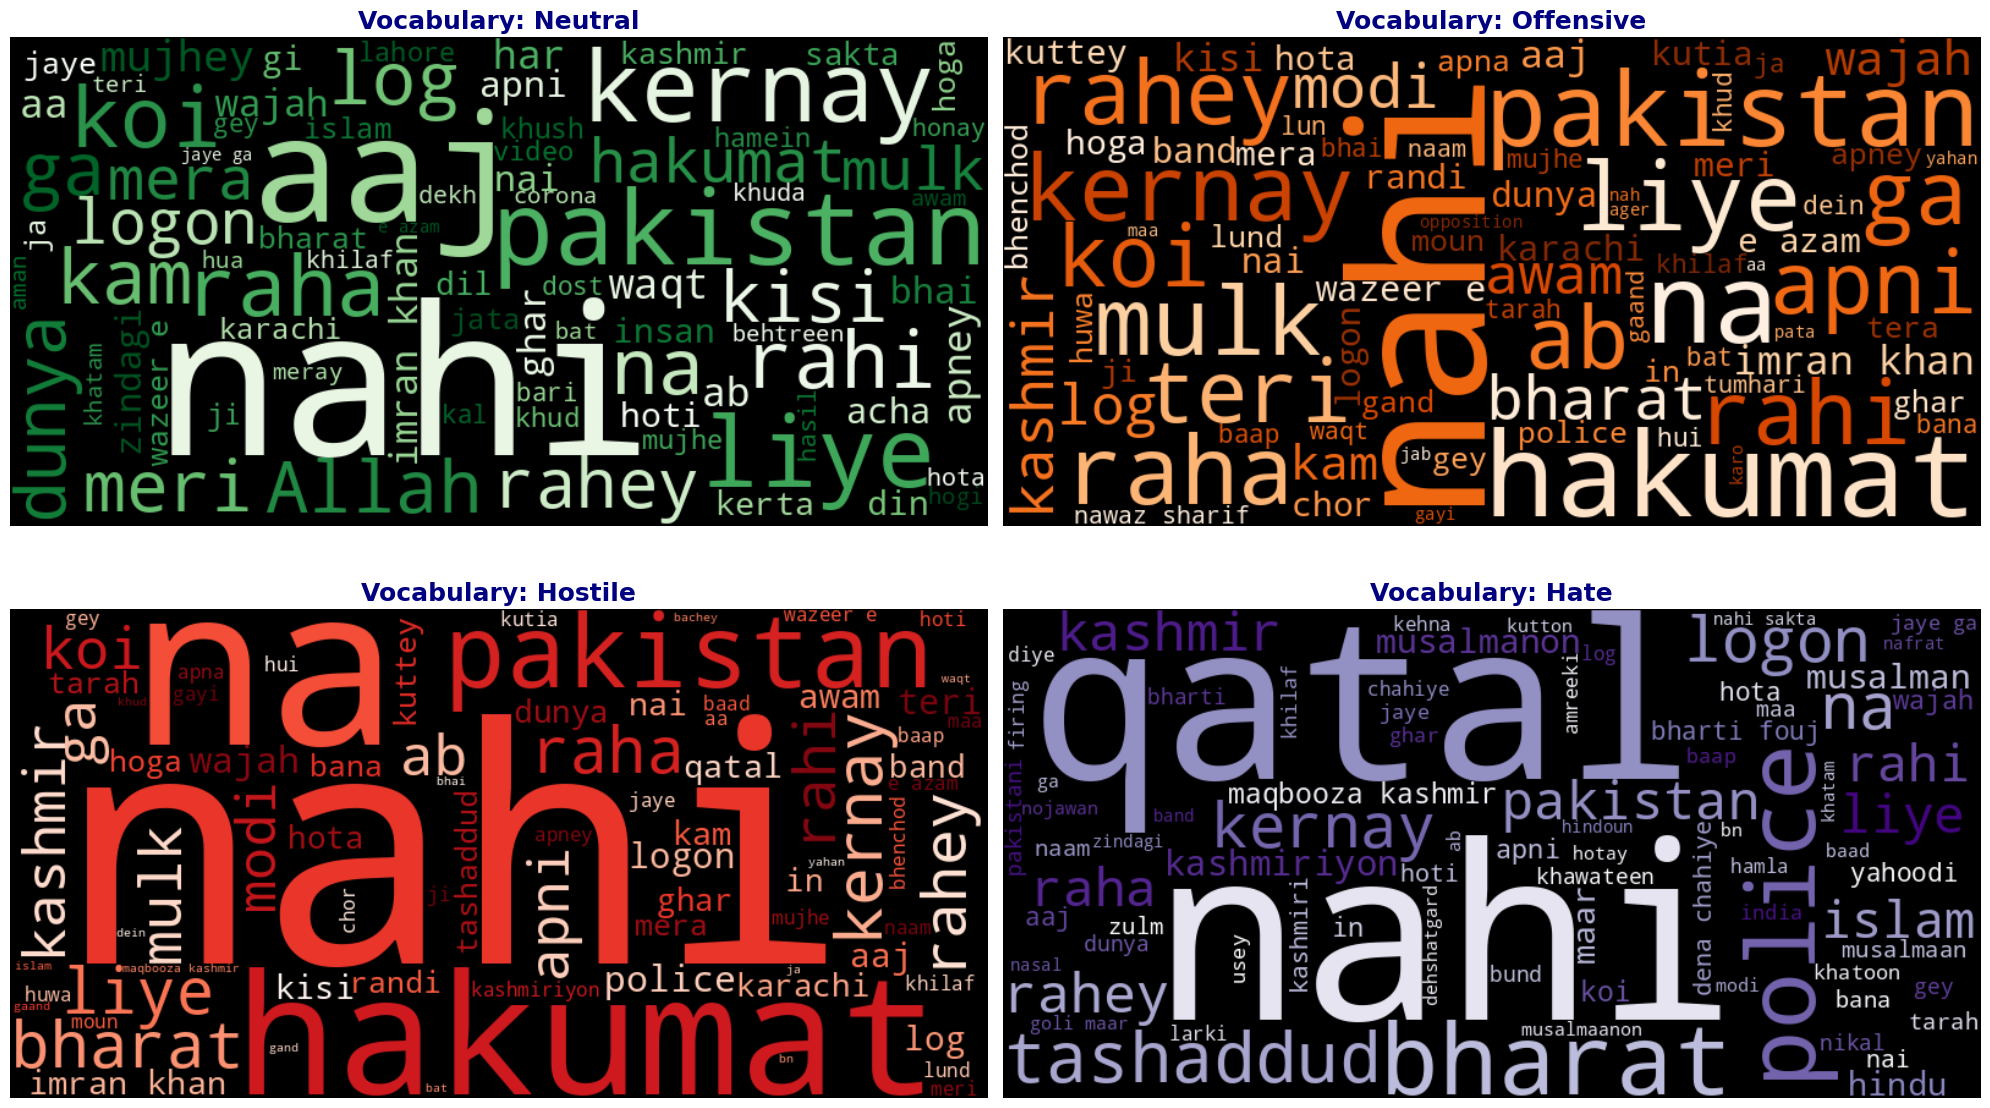

In [6]:
stopwords_ur = set([
    'hai', 'hain', 'hun', 'hoon', 'h', 'hn', 'hy', 'ny', 'tei', 't', 'th',
    'tha', 'thi', 'thay', 'the', 'thy', 'hein', 'han', 'ho', 'hu', 
    
    'main', 'mein', 'me', 'mai', 'ma', 'm', 'hum', 'ham', 'hm',
    'tum', 'tu', 't', 'ap', 'aap', 'wo', 'woh', 'ye', 'yeh', 'is', 'us', 'jo',
    
    'ko', 'k', 'ka', 'ki', 'ke', 'kay',
    'se', 'say', 'sey', 'ne', 'nay',
    'par', 'per', 'pr', 'pe', 'py', 'po',
    'tak', 'tk', 'mein',
    
    'kar', 'ker', 'kr', 'karna', 'kerna', 'kry', 'kray', 'karen', 'kerne',
    'kia', 'kiya', 'kya', 'kyun', 'kion', 'keun',
    'gya', 'gaya', 'gaye', 'gai', 'gay',
    'diya', 'dia', 'de', 'dy', 'do', 'di',
    'liya', 'lia', 'lo', 'le', 'ly',
    
    'aur', 'or', 'ar', 'o',
    'to', 'tou', 'toh',
    'bhi', 'b', 'be',
    'hi', 'he',
    'bas', 'bs',
    'wala', 'waley', 'wali', 'walon', 'waly',
    'sab', 'sb', 'sub',
    'agar', 'agr', 'magar', 'mgr', 'lekin', 'lkn',
    'phir', 'phr',
    'kuch', 'kch',
    'sirf', 'srf',
    'eik', 'aik', 'ek', 'ak',
    'bohut', 'bohat', 'bht', 'bahut',
    'saal', 'saath', 'sath'
])

print("Generating Word Clouds...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
classes = ['Neutral', 'Offensive', 'Hostile', 'Hate']
colors = ['Greens', 'Oranges', 'Reds', 'Purples'] 

for i, label in enumerate(classes):
    ax = axes[i // 2, i % 2]
    
    subset_text = " ".join(df[df['label_name'] == label]['text'].astype(str).tolist())
    
    wc = WordCloud(
        width=800, height=400, 
        background_color='black', 
        stopwords=stopwords_ur,
        colormap=colors[i], 
        max_words=80,
        min_font_size=10
    ).generate(subset_text)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Vocabulary: {label}", fontsize=18, fontweight='bold', color='navy')
    ax.axis('off')

plt.tight_layout()
plt.show()

Calculating t-SNE Clusters...


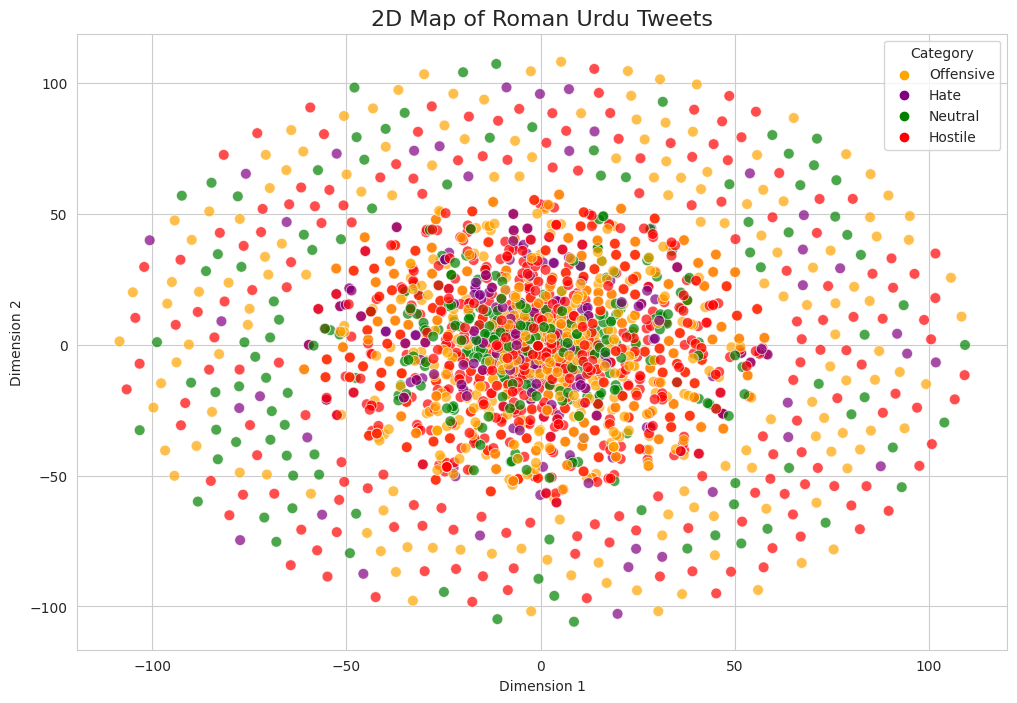

In [7]:
print("Calculating t-SNE Clusters...")

df_sample = df.sample(n=min(2000, len(df)), random_state=42).copy()

tfidf = TfidfVectorizer(max_features=500, stop_words=list(stopwords_ur))
tfidf_matrix = tfidf.fit_transform(df_sample['text']).toarray()

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(tfidf_matrix)

df_sample['x_tsne'] = tsne_results[:, 0]
df_sample['y_tsne'] = tsne_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x_tsne', y='y_tsne', 
    hue='label_name', 
    palette={'Neutral': 'green', 'Offensive': 'orange', 'Hostile': 'red', 'Hate': 'purple'},
    data=df_sample,
    alpha=0.7,
    s=60
)
plt.title("2D Map of Roman Urdu Tweets", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Category")
plt.show()

In [8]:
print("Checking for Metadata (Hashtags/Mentions)...")

total_hashtags = df['text'].apply(lambda x: len(re.findall(r'#\w+', str(x)))).sum()
total_mentions = df['text'].apply(lambda x: len(re.findall(r'@\w+', str(x)))).sum()
total_urls = df['text'].apply(lambda x: len(re.findall(r'http\S+', str(x)))).sum()

print(f"- Total Hashtags found: {total_hashtags}")
print(f"- Total Mentions found: {total_mentions}")
print(f"- Total URLs found:     {total_urls}")

if total_hashtags == 0 and total_mentions == 0:
    print("\nConclusion: The dataset is pre-cleaned. No need for hashtag/mention removal.")
else:
    print("\nNote: Some metadata exists. The model will treat them as normal text.")

Checking for Metadata (Hashtags/Mentions)...
- Total Hashtags found: 0
- Total Mentions found: 0
- Total URLs found:     0

Conclusion: The dataset is pre-cleaned. No need for hashtag/mention removal.


In [9]:
model_name = "cardiffnlp/twitter-xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loaded Tokenizer: {model_name}")

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded Tokenizer: cardiffnlp/twitter-xlm-roberta-base


In [10]:
class Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'].tolist(), 
    df['severity_score'].tolist(),
    test_size=0.2, 
    random_state=42, 
    stratify=df['severity_score']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [12]:
train_dataset = Dataset(X_train, y_train, tokenizer)
val_dataset = Dataset(X_val, y_val, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)

In [13]:
print(f"Data Prepared:")
print(f"- Training Set:   {len(train_dataset)} samples")
print(f"- Validation Set: {len(val_dataset)} samples")
print(f"- Test Set:       {len(test_dataset)} samples")

Data Prepared:
- Training Set:   6855 samples
- Validation Set: 857 samples
- Test Set:       857 samples


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.to(device)
print(f"Model loaded on: {device}")

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model loaded on: cuda


In [16]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
    report_to="none"
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting Training...")
gc.collect()
torch.cuda.empty_cache()

trainer.train()

Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.259000,1.248117,0.416569,0.245687
2,1.213300,1.175947,0.406068,0.364240
3,1.091600,1.101286,0.458576,0.432508
4,1.017800,1.064244,0.448075,0.395053
5,0.915600,1.005370,0.507585,0.391656
6,0.824800,1.058260,0.480747,0.441912
7,0.737600,1.075241,0.473746,0.449239
8,0.704200,1.137005,0.423571,0.424925
9,0.677100,1.188007,0.409568,0.404095
10,0.646300,1.170895,0.409568,0.400796


TrainOutput(global_step=2150, training_loss=0.9122487658123637, metrics={'train_runtime': 1513.4918, 'train_samples_per_second': 45.293, 'train_steps_per_second': 1.421, 'total_flos': 4509146681395200.0, 'train_loss': 0.9122487658123637, 'epoch': 10.0})

second approach

In [18]:
print("Merging Labels into Binary (Safe vs Toxic)...")

df['severity_score'] = df['severity_score'].apply(lambda x: 0 if x == 0 else 1)

print("New Class Counts:")
print(df['severity_score'].value_counts())

Merging Labels into Binary (Safe vs Toxic)...
New Class Counts:
severity_score
1    7145
0    1424
Name: count, dtype: int64


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'].tolist(), df['severity_score'].tolist(), test_size=0.2, random_state=42, stratify=df['severity_score']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

train_dataset = Dataset(X_train, y_train, tokenizer)
val_dataset = Dataset(X_val, y_val, tokenizer)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [21]:
training_args = TrainingArguments(
    output_dir='./results_binary',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
    report_to="none"
)

def compute_metrics_binary(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_binary,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting Binary Training...")
gc.collect()
torch.cuda.empty_cache()
trainer.train()

Starting Binary Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.435600,0.437171,0.834306,0.909669
2,0.391300,0.330923,0.865811,0.923384
3,0.322700,0.299008,0.885648,0.935356
4,0.261300,0.259501,0.912485,0.950033
5,0.198100,0.255171,0.917153,0.951864
6,0.145100,0.306515,0.913652,0.950732
7,0.116900,0.404037,0.907818,0.947438
8,0.082100,0.378541,0.926488,0.957461
9,0.066700,0.372196,0.927655,0.957534
10,0.042000,0.416178,0.921820,0.954943


TrainOutput(global_step=2580, training_loss=0.18984371386757193, metrics={'train_runtime': 1820.7261, 'train_samples_per_second': 75.3, 'train_steps_per_second': 2.362, 'total_flos': 5410878853478400.0, 'train_loss': 0.18984371386757193, 'epoch': 12.0})

In [23]:
import gc
import torch

train_dataset = None
val_dataset = None

gc.collect()

torch.cuda.empty_cache()

Running predictions on the Test Set...



Model Performance Report:
                      precision    recall  f1-score   support

      Safe (Neutral)       0.84      0.68      0.75       143
Toxic (Hate/Hostile)       0.94      0.97      0.96       714

            accuracy                           0.93       857
           macro avg       0.89      0.83      0.85       857
        weighted avg       0.92      0.93      0.92       857



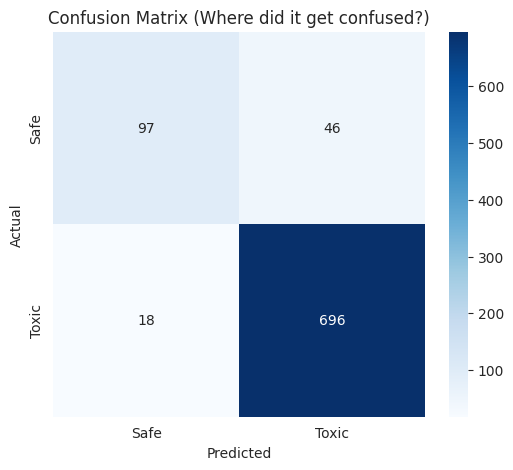

In [24]:
print("Running predictions on the Test Set...")
test_dataset = Dataset(X_test, y_test, tokenizer)
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

print("\nModel Performance Report:")
print(classification_report(true_labels, preds, target_names=['Safe (Neutral)', 'Toxic (Hate/Hostile)']))

cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Where did it get confused?)')
plt.show()

# BERT

In [25]:
try:
    del model
    del trainer
    del tokenizer
except:
    pass

gc.collect()
torch.cuda.empty_cache()
print("GPU Memory Cleaned.")

GPU Memory Cleaned.


In [26]:
model_name = "l3cube-pune/hing-bert"
print(f" Loading Model: {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)

 Loading Model: l3cube-pune/hing-bert...


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [27]:
train_dataset = Dataset(X_train, y_train, tokenizer)
val_dataset = Dataset(X_val, y_val, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Starting BERT Training...")
trainer.train()

Starting BERT Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.345900,0.326861,0.855309,0.915068
2,0.277000,0.240231,0.905484,0.944176
3,0.171700,0.343240,0.907818,0.947438
4,0.086000,0.276829,0.933489,0.961092
5,0.022600,0.361534,0.933489,0.961145


TrainOutput(global_step=1075, training_loss=0.19229678275973297, metrics={'train_runtime': 523.3907, 'train_samples_per_second': 65.486, 'train_steps_per_second': 2.054, 'total_flos': 2254532855616000.0, 'train_loss': 0.19229678275973297, 'epoch': 5.0})

In [31]:
print("\nEvaluating BERT on Test Set...")
preds_output = trainer.predict(test_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)

print("\nBERT Classification Report:")
print(classification_report(y_test, y_preds, target_names=['Safe', 'Toxic']))


Evaluating BERT on Test Set...



BERT Classification Report:
              precision    recall  f1-score   support

        Safe       0.87      0.66      0.75       143
       Toxic       0.93      0.98      0.96       714

    accuracy                           0.93       857
   macro avg       0.90      0.82      0.85       857
weighted avg       0.92      0.93      0.92       857

